# Projet QI - Propagation du coronavirus MERS-CoV en Corée du Sud

**Groupe : Saimourya SURABHI & Maéva CAILLAT**

## 2.0 Au préalable

In [ ]:
pip install openturns

In [ ]:
%matplotlib inline
from math import *
import numpy as  np
from pylab import *
import openturns as ot

In [ ]:
# Set the ODE solver parameters
ot.ResourceMap.SetAsScalar("Fehlberg-InitialStep", 1.0e-1)
ot.ResourceMap.SetAsScalar("Fehlberg-LocalPrecision", 1.0e-6)
ot.ResourceMap.SetAsUnsignedInteger("Fehlberg-DefaultOrder", 4)

## 2.1 Modélisation probabilistique

### Question 1

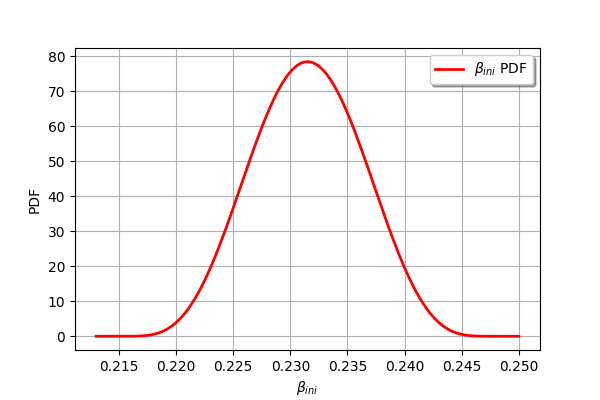

In [ ]:
beta_ini =  ot.Beta(5.5, 5.5, 0.215, 0.248)
beta_ini.setDescription([r"$\beta_{ini}$"])
beta_ini.drawPDF()

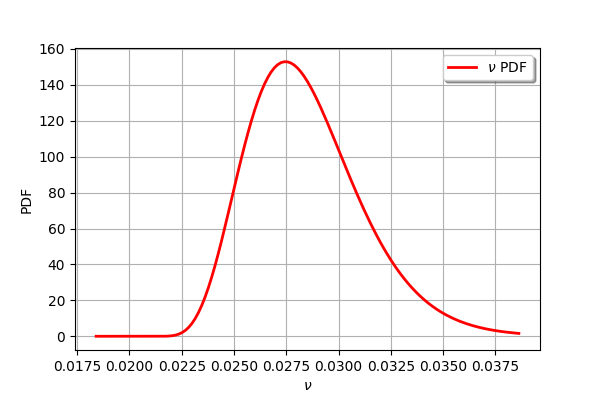

In [ ]:
nu = ot.Gamma(7.3, 975, 0.021)
nu.setDescription([r"$\nu$"])
nu.drawPDF()

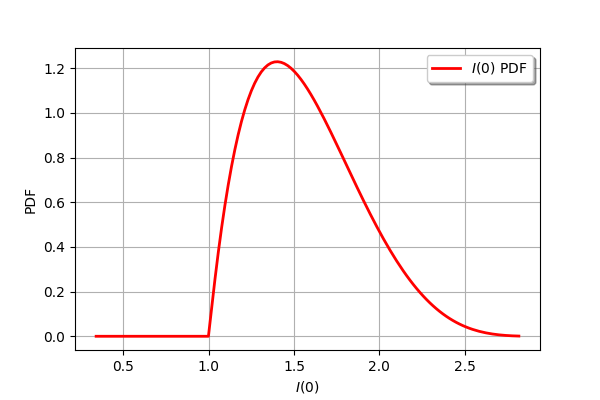

In [ ]:
I0 = ot.Beta(2, 5, 1, 3)
I0.setDescription([r"$I(0)$"])
I0.drawPDF()

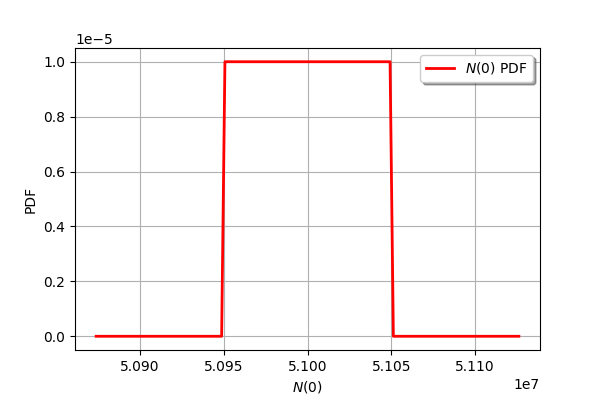

In [ ]:
N0 = ot.Uniform(50950000, 51050000)
N0.setDescription([r"$N(0)$"])
N0.drawPDF()

### Question 2

Graphiquement, la probabilité de l'événement { $R_0 < 1$ } est très proche de 0 ce qui laisse à penser que l'extinction spontanée de l'épidémie est quasiment improbable. </br>
On vérifie numériquement : $P(R0 < 1) = F_{R0}(1) = 9.99 * 10^{-15}$ </br>
Ainsi, la probabilité d'une extinction spontanée de l'épidémie est quasi-nulle.

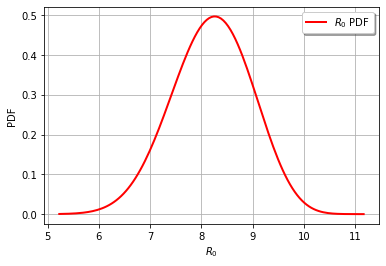

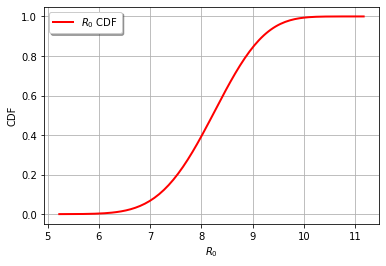

P(R0<1) =  9.992007221624932e-15


In [ ]:
R0 = beta_ini / nu
R0.setDescription([r"$R_{0}$"])
ot.Show(R0.drawPDF())
ot.Show(R0.drawCDF())
print("P(R0<1) = ", R0.computeCDF(1))

### Question 3

Graphiquement, pour $t = t_{new}$, l'événement { $R_0 < 1 $ } est très proche de 1. On vérifie numériquement : $P(R0 < 1) = F_{R0}(1) \simeq 1$. </br>
Ainsi, l'épidémie va très probablement s'éteindre.

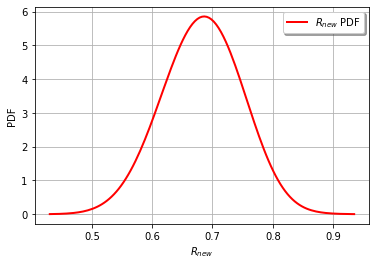

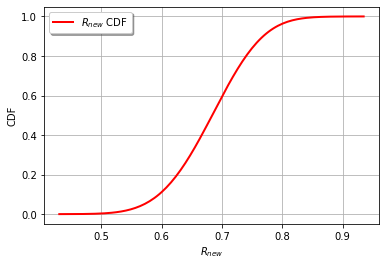

P(Rnew<1) =  0.9999986132774975


In [ ]:
t_new = ot.Uniform(24, 29)
t_new.setDescription([r"$t_{new}$"])

beta_new = ot.Gamma(2.8, 2870, 0.0183)
beta_new.setDescription([r"$\beta_{new}$"])

R_new = beta_new / nu
R_new.setDescription([r"$R_{new}$"])
graph_pdf = ot.Show(R_new.drawPDF())
graph_cdf = ot.Show(R_new.drawCDF())
print("P(Rnew<1) = ", R_new.computeCDF(1))

### Question 4

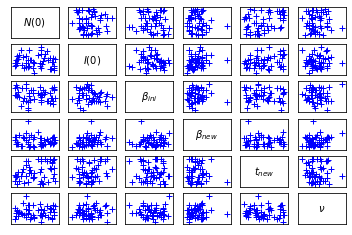

Moyennes des sources d'incertitudes (lois marginales) : 


class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=1 dimension=6 description=[$N(0)$,$I(0)$,$\beta_{ini}$,$\beta_{new}$,$t_{new}$,$\nu$] data=[[5.1e+07,1.57143,0.2315,0.0192756,26.5,0.0284872]]

In [ ]:
marginales = [N0, I0, beta_ini, beta_new, t_new, nu]

# Loi jointe de X
dist_X = ot.ComposedDistribution(marginales)
ot.Show(ot.Pairs(dist_X.getSample(50)))

# Vecteur des sources d'incertitudes
X = ot.RandomVector(dist_X)

# Moyennes des sources d'incertitudes pour mieux visualiser le vecteur X
print("Moyennes des sources d'incertitudes (lois marginales) : ")
moyenne = ot.Sample([dist_X.getMean()])
moyenne.setDescription(dist_X.getDescription())
moyenne

## 2.2 Création de la variable d'intérêt

### Question 1

In [ ]:
# Fonction déjà fournie
def buildFunction(beta, nu, N, t0):
    '''
       Build the transition function of the SIR model given the values of
       beta and nu
    '''
    f = ot.SymbolicFunction(['t', 'S', 'I', 'R'], [str(-beta/N)  + '*S*I', str(beta/N) + 'S*I-' + str(nu) + '*I', str(nu) + '*I'])
    phi = ot.ParametricFunction(f, [0], [t0])
    return phi

In [ ]:
def computeMax(X):
    '''
       Compute the maximum number of people in group I over [0,T]
       Note: the ODE is integrated using an adaptive method, and the
       measurement is done with a time step of one hour
    '''
    dt = 1.0 / 24.0
    N0 = X[0]
    I0 = X[1]
    betaIni = X[2]
    betaNew = X[3]
    tNew = X[4]
    nu = X[5]
    
    # First phase, no intervention
    phi = buildFunction(betaIni, nu, N0, 0.0)
    solver = ot.Fehlberg(phi)
    initialState = [N0-I0, I0, 0.0]
    nt = int(tNew / dt) + 1
    dt = tNew / (nt - 1)
    grid = ot.RegularGrid(0.0, dt, nt).getVertices().asPoint()
    result = solver.solve(initialState, grid)
    
    # Extract the maximum number of infected people in phase 0
    max0 = result.getMax()[1]
    
    # Second phase, after intervention
    phi = buildFunction(betaNew, nu, N0, tNew)
    solver = ot.Fehlberg(phi)
    initialState = result[-1]
    grid = ot.RegularGrid(tNew, dt, int(300 / dt + 1)).getVertices().asPoint()
    result = solver.solve(initialState, grid)
    
    # Extract the maximum number of infected people in phase 1
    max1 = result.getMax()[1]
    return [max(max0, max1)]

In [ ]:
f = ot.PythonFunction(6, 1, computeMax, n_cpus = -1)

### Question 2

In [ ]:
Y = ot.CompositeRandomVector(f, X)

### Question 3

Moyenne y = 359.7826906834805 personnes infectées durant la période [0,T]
Ecart-type y = 142.80745456902326 personnes infectées durant la période [0,T]


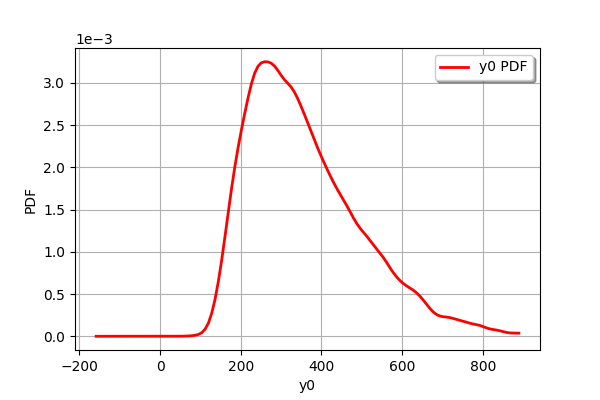

In [ ]:
n = 10000
# Echantillon de taille n de Y
sample_Y = Y.getSample(n)

## Estimation par noyaux
dist_Y = ot.KernelSmoothing().build(sample_Y)

# Estimation par noyaux de la moyenne de Y
y = dist_Y.getMean()[0]
print("Moyenne y =", y, "personnes infectées durant la période [0,T]")

# Estimation par noyaux de l'écart-type de Y
sigma = dist_Y.getStandardDeviation()[0]
print("Ecart-type y =", sigma, "personnes infectées durant la période [0,T]")

# Estimation par noyaux de la densité de Y
dist_Y.drawPDF()

In [ ]:
# On archive cet échantillon au format CSV
sample_Y.exportToCSVFile('Echantillon_Y_taille_1000.csv')

## 2.3 Calcul de probabilité d'événements rares

### Question 1

In [ ]:
sample_Y_array = np.array(sample_Y)
p = 0
for i in range(n):
    if (sample_Y_array[i] > 1000):
        p += 1
print("P(E) estimée avec l'échantillon de Y vaut environ : ", p/n)

P(E) estimée avec l'échantillon de Y vaut environ :  0.0003


### Question 2

In [ ]:
## Méthode FORM : algo d'optimisation Cobyla et initialisation par le point moyen de X
# Evénement
E = ot.ThresholdEvent(Y, ot.Greater(), 1000)

form = ot.FORM(ot.Cobyla(), E, X.getMean())
# Nombre d'appels avant
n0Ef = f.getEvaluationCallsNumber()
form.run()
result_form = form.getResult()

# Approximation de la probabilité de l'événement E
p_form = result_form.getEventProbability()
print("Probabilité FORM = %.2e "% p_form)

# Nombre d'appels après
n1Ef = f.getEvaluationCallsNumber()

# Nombre d'appels total
print("Nombre d'appels à l'évaluation du modèle = ", n1Ef - n0Ef)

Probabilité FORM = 1.56e-03 
Nombre d'appels à l'évaluation du modèle =  113


In [ ]:
## Méthode SORM : algo d'optimisation Cobyla et initialisation par le point moyen de X

sorm = ot.SORM(ot.Cobyla(), E, X.getMean())
# Nombre d'appels avant
n0Es = f.getEvaluationCallsNumber()
sorm.run()
result_sorm = sorm.getResult()

# Approximation de la probabilité de l'événement E
p_sorm = result_sorm.getEventProbabilityBreitung()
print("Probabilité SORM = %.2e "% p_sorm)

# Nombre d'appels après
n1Es = f.getEvaluationCallsNumber()

# Nombre d'appels total
print("Nombre d'appels à l'évaluation du modèle = ", n1Es - n0Es)

Probabilité SORM = 1.03e-05 
Nombre d'appels à l'évaluation du modèle =  210


La probabilité obtenue avec la méthode FORM est proche de celle obtenue à partir de l'échantillon de Y ci-dessus (1.56e-03 contre 1.10e-03). En revanche, la méthode SOR obtient une probabilité bien plus faible pour E de 1.03e-05. Dans tous les cas, l'événement E a une probabilité proche de 0 et les hôpitaux coréens devraient avoir une capacité d'accueil suffisante.

### Question 3

In [ ]:
Nest = int(100 / p_form)
print("Nombre de simulations estimé = %.2e" % Nest)

Nombre de simulations estimé = 6.40e+04


La différence entre les approximations FORM et SORM obtenues à la question précédente incite à valider le calcul par une méthode de simulation, par exemple la méthode de Monte Carlo simple. Cette dernière a une précision relative en $O(\frac{1}{\sqrt{Np}})$.
Si on veut un coefficient de variation de 0.1, l'ordre de grandeur du nombre d'évaluations est donc de $N = \frac{100}{p} \simeq 6.40*10^{4}$ évaluations.

### Question 4

In [ ]:
algo = ot.ProbabilitySimulationAlgorithm(E, ot.MonteCarloExperiment())
algo.setBlockSize(100)
algo.setMaximumOuterSampling(1000)
algo.run()
print(algo.getResult())

probabilityEstimate=7.100000e-04 varianceEstimate=7.165919e-09 standard deviation=8.47e-05 coefficient of variation=1.19e-01 confidenceLength(0.95)=3.32e-04 outerSampling=1000 blockSize=100


La probabilité de E obtenu à ci-dessus est de 8.30e-04. Elle est donc près de 2 fois plus petite que celle obtenue précédemment avec la méthode FORM (1.56e-03), mais reste très proche de 0 dans les deux cas. <br>
Le coefficient de variation de l'estimateur est de 1.10e-01.
Conclusion : d'après cette étude, le gouvernement coréen sera en mesure d'accueillir les personnes infectées dans ses hôpitaux.

### Question 1

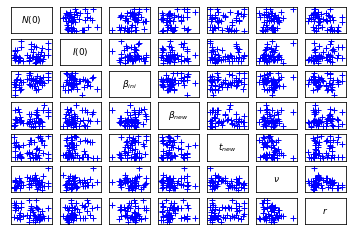

In [ ]:
# Nouveau facteur multiplicatif
r =  ot.Beta(2, 4, 0.9, 1.2)
r.setDescription([r"$r$"])

marginales_r = list(marginales)
marginales_r.append(r)

# Loi jointe de X_tilde
dist_X_tilde = ot.ComposedDistribution(marginales_r)
ot.Show(ot.Pairs(dist_X_tilde.getSample(50)))

# Vecteur des sources d'incertitudes correspondant à cette modélisation augmentée
X_tilde = ot.RandomVector(dist_X_tilde)

### Question 2

In [ ]:
def computeMaxFuzzy(X):
    '''
       Compute the maximum number of people in group I over [0,T]
       Note: the ODE is integrated using an adaptive method, and the
       measurement is done with a time step of one hour
    '''
    dt = 1.0 / 24.0
    N0 = X[0]
    I0 = X[1]
    betaIni = X[2]
    betaNew = X[3]
    tNew = X[4]
    nu = X[5]
    r = X[6]
    
    # First phase, no intervention
    phi = buildFunction(betaIni, nu, N0, 0.0)
    solver = ot.Fehlberg(phi)
    initialState = [N0-I0, I0, 0.0]
    nt = int(tNew / dt) + 1
    dt = tNew / (nt - 1)
    grid = ot.RegularGrid(0.0, dt, nt).getVertices().asPoint()
    result = solver.solve(initialState, grid)
    
    # Extract the maximum number of infected people in phase 0
    max0 = result.getMax()[1]
    
    # Second phase, after intervention
    phi = buildFunction(betaNew, nu, N0, tNew)
    solver = ot.Fehlberg(phi)
    initialState = result[-1]
    grid = ot.RegularGrid(tNew, dt, int(300 / dt + 1)).getVertices().asPoint()
    result = solver.solve(initialState, grid)
    
    # Extract the maximum number of infected people in phase 1
    max1 = result.getMax()[1]
    return [r*max(max0, max1)]

In [ ]:
f_tilde = ot.PythonFunction(7, 1, computeMaxFuzzy, n_cpus = -1)
Y_tilde = ot.CompositeRandomVector(f_tilde, X_tilde)

### Question 3

In [ ]:
# Evénement
E_tilde = ot.ThresholdEvent(Y_tilde, ot.Greater(), 1000)

### Question 4

In [ ]:
## Méthode FORM : algo d'optimisation Cobyla et initialisation par le point moyen de X_tilde
form_tilde = ot.FORM(ot.Cobyla(), E_tilde, X_tilde.getMean())
# Nombre d'appels avant
n0Eft = f_tilde.getEvaluationCallsNumber()
form_tilde.run()
result_form_tilde = form_tilde.getResult()

# Approximation de la probabilité de l'événement E_tilde
p_form_tilde = result_form_tilde.getEventProbability()
print("Probabilité FORM = %.2e "% p_form_tilde)

# Nombre d'appels après
n1Eft = f_tilde.getEvaluationCallsNumber()

# Nombre d'appels total
print("Nombre d'appels = ", n1Eft - n0Eft)

Probabilité FORM = 1.89e-03 
Nombre d'appels =  115


Avec cette modélisation, $P(E)$ vaut environ 1.89e-03, ce qui légèrement plus grand que la modélisation précédente (1.56e-03) mais qui reste du même ordre de grandeur. Ainsi, cette nouvelle modélisation plus complexe ne remet pas en question la capacité du gouvernement à accueillir les malades dans ses hôpitaux.

## 2.4 Analyse de sensibilité

### Question 1

In [ ]:
size = 4096
ot.ResourceMap.SetAsString("SobolIndicesExperiment-SamplingMethod", "QMC")
inputDesign = ot.SobolIndicesExperiment(dist_X_tilde, size).generate()
outputDesign = f_tilde(inputDesign)

# Algo d'analyse de sensibilité de Saltelli
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

# Indices de Sobol du premier ordre
SobolFirst = sensitivityAnalysis.getFirstOrderIndices()
print(SobolFirst)

# Indices de Sobol totaux
SobolTotal = sensitivityAnalysis.getTotalOrderIndices()
print(SobolTotal)

[-0.00255562,0.259976,0.107376,-0.00255562,0.536247,0.0308397,0.0159091]
[-4.12807e-11,0.289013,0.121092,-1.0291e-11,0.579135,0.0392196,0.0212874]


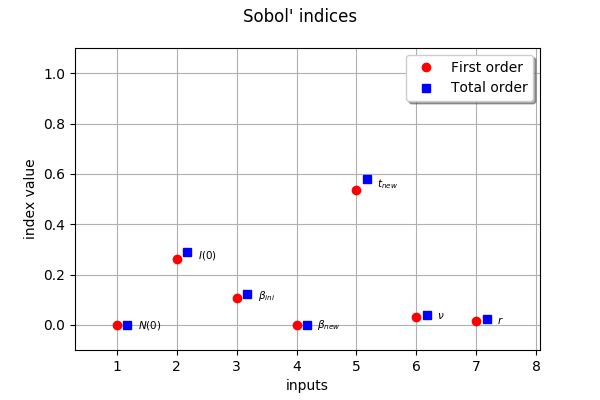

In [ ]:
# On trace ces indices de Sobol
inputDescription = X_tilde.getDescription()
ot.SobolIndicesAlgorithm.DrawSobolIndices(inputDescription, np.array(SobolFirst), np.array(SobolTotal))

Le facteur le plus sensible est $t_{new}$, qui représente la date où les mesures de contrôle de l'épidémie prises par le gouvernement coréen prennent leur plein effet. Cela semble logique car plus vite le gouvernement coréen met en place des mesures sanitaires adéquates, plus vite le coronavirus sera éradiqué. </br>
Les deuxième et troisième facteurs les plus sensibles sont $I(0)$ et $\beta_{ini}$, soit respectivement le nombre initial de personnes infectées et un facteur sensible aux mesures prises par le gouvernement initialement. </br>
Enfin, les 4 autres facteurs sont beaucoup moins sensibles (sensibilité proche de 0). On remarque notamment que la taille de la population initiale n'est pas un facteur sensible.

### Question 2

In [ ]:
size = 100000
sample_X = X_tilde.getSample(size)
sample_Y = f_tilde(sample_X)
conditional_sample = ot.Sample(0, sample_X.getDimension())
n0 = f_tilde.getEvaluationCallsNumber()
j = 0

while (conditional_sample.getSize() < 100 and f_tilde.getEvaluationCallsNumber()-n0 < 100000 and j<size):
    if (sample_Y[j,0] > 1000):
        conditional_sample.add(sample_X[j])
    j += 1

print("size = ", conditional_sample.getSize())

esperance_conditionnelle = conditional_sample.computeMean()
print("E[X|f(X)\in D_f]=", esperance_conditionnelle)

size =  80
E[X|f(X)\in D_f]= [5.0999e+07,2.32661,0.239197,0.0192258,28.6609,0.0267524,1.03943]


In [ ]:
# Facteurs d'importance dans l'espace standard
u = dist_X_tilde.getIsoProbabilisticTransformation()(esperance_conditionnelle)
input_dimension = dist_X_tilde.getDimension()
IF = ot.Sample(1, input_dimension)
IF.setDescription(dist_X_tilde.getDescription())
for j in range(input_dimension):
    IF[0, j] = (100.0 * u[j]**2 / u.normSquare())
print("Importance factors (%) : ")
IF


Importance factors (%) : 


class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=1 dimension=7 description=[$N(0)$,$I(0)$,$\beta_{ini}$,$\beta_{new}$,$t_{new}$,$\nu$,$r$] data=[[0.00605916,43.388,25.8458,0.131324,22.292,3.09348,5.24329]]

**Comparaison à la hiérarchisation des variables obtenue à partir des indices de Sobol :** cette hiérarchisation est quasi-identique à celle des indices de Sobol, à l'exception près que le facteur le plus sensible est $I(0)$ ici et non $t_{new}$. </br>

**Interprétation :** tout comme pour l'analyse des indices Sobol, les 3 facteurs les plus importants, qui sont aussi les plus sensibles, sont $I(0)$, $\beta_{ini}$ et $t_{new}$. $\beta_{new}$ est peu influent car c'est surtout le temps de réaction du gouvernement $t_{new}$ qui est important. $\nu$ est peu influent car il est l'inverse de la durée de la période contagieuse et on peut supposer que le cercle des proches des malades ne varie pas au cours du temps. Par ailleurs, $N(0)$ et $I(0)$, respectivement la population totale de la Corée et le nombre d'infectés initialement ont des rôles très différents. En effet, une variation de la taille de la population totale ne changerait pas grand chose au taux de transmission de la maladie, contrairement au nombre d'infectés initialement.

**Conclusion :** les résultats de l'analyse de sensibilité montrent que la maîtrise de Y ne suffit pas à contrôler les effets de l'épidémie.